In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
from  scipy import ndimage
import matplotlib
from scipy import stats

%matplotlib inline
# import jupyternotify
# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)

In [2]:
data = pd.read_csv('Downloads/ExoTrain.csv')
label_1 = data[data.LABEL==1]
label_2 = data[data.LABEL==2]
train_1 = label_1.iloc[0:2620,:]
train_2 = label_2.iloc[0:22,:]
test_1 = label_1.iloc[2620:,:]
test_2 = label_2.iloc[22:,:]
train_frames = [train_2, train_1]
test_frames = [test_2, test_1]
extrain = pd.concat(train_frames)
extest = pd.concat(test_frames)
#extrain = train.sample(frac=1) #randomize
#extest = test.sample(frac=1) #write a function as too much repitition

In [9]:
extrain.to_csv('extrain.csv')

In [10]:
extest.to_csv('extest.csv')

In [5]:
def detrender_normalizer(X):
    flux1 = X
    flux2 = ndimage.filters.gaussian_filter(flux1, sigma=10)
    flux3 = flux1 - flux2
    flux3normalized = (flux3-np.mean(flux3)) / (np.max(flux3)-np.min(flux3))
    return flux3normalized

In [6]:
extrain.iloc[:,1:] = extrain.iloc[:,1:].apply(detrender_normalizer,axis=1)
extest.iloc[:,1:] = extest.iloc[:,1:].apply(detrender_normalizer,axis=1)

In [5]:
def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    '''
    Since we are looking at dips in the data, we should remove upper outliers.
    The function is taken from here:
    https://www.kaggle.com/muonneutrino/exoplanet-data-visualization-and-exploration
    '''
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values:
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
       # print(sorted_values[:30])
        for j in range(remove):
            idx = sorted_values.index[j]
            #print(idx)
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            #print(idx,idx_num)
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)] # corrected from 'FLUX-' to 'FLUX.'
                
                count += 1
            new_val /= count # count will always be positive here
            #print(new_val)
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                df.set_value(i,idx,new_val)
        
            
    return df

In [6]:
extrain.iloc[:,1:] = reduce_upper_outliers(extrain.iloc[:,1:])
extest.iloc[:,1:] = reduce_upper_outliers(extest.iloc[:,1:]) #time_taking

In [3]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
extrain.LABEL.value_counts()

1    2620
2      22
Name: LABEL, dtype: int64

In [9]:
extest.LABEL.value_counts()

1    1307
2      11
Name: LABEL, dtype: int64

Therefore, we either need to bootstrap the data to get more LABEL = 2 observations, or we can synthetically generate new data using SMOTE approach, see more information [here](https://beckernick.github.io/oversampling-modeling/). Bootstrapping/using SMOTE with impbalanced data should proceed in the following order:
1. Perform stratified test-train separation on the data
2. Boostrap/use SMOTE on the train data, leave test data untouched
3. Perform model fit on the bootstrapped train data
4. Assess you model's performance using untouched test data  
The code below also performs K-fold validation with the default of 5 folds:

In [4]:
from imblearn.over_sampling import SMOTE

In [34]:
def model_evaluator(X, y, model, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits)
    
    bootstrapped_accuracies = list()
    bootstrapped_precisions = list()
    bootstrapped_recalls    = list()
    bootstrapped_f1s        = list()
    
    SMOTE_accuracies = list()
    SMOTE_precisions = list()
    SMOTE_recalls    = list()
    SMOTE_f1s        = list()
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
                
        df_train    = X_train.join(y_train)
        df_planet   = df_train[df_train.LABEL == 2].reset_index(drop=True)
        df_noplanet = df_train[df_train.LABEL == 1].reset_index(drop=True)
        df_boot     = df_noplanet
                        
        index = np.arange(0, df_planet.shape[0])
        temp_index = np.random.choice(index, size=df_noplanet.shape[0])
        df_boot = df_boot.append(df_planet.iloc[temp_index])
        
        df_boot = df_boot.reset_index(drop=True)
        X_train_boot = df_boot.drop('LABEL', axis=1)
        y_train_boot = df_boot.LABEL
                    
        est_boot = model.fit(X_train_boot, y_train_boot)
        y_test_pred = est_boot.predict(X_test)
        
        #print(y_test)
      #  print(y_test_pred)
        bootstrapped_accuracies.append(accuracy_score(y_test.round(), y_test_pred.round()))
        bootstrapped_precisions.append(precision_score(y_test, y_test_pred.round(), pos_label=2))
        bootstrapped_recalls.append(recall_score(y_test, y_test_pred.round(), pos_label=2))
        bootstrapped_f1s.append(f1_score(y_test, y_test_pred.round(), pos_label=2))
    
        sm = SMOTE(ratio = 1.0)
        X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
                    
        est_sm = model.fit(X_train_sm, y_train_sm)
        y_test_pred = est_sm.predict(X_test)
        
        SMOTE_accuracies.append(accuracy_score(y_test, y_test_pred))
        SMOTE_precisions.append(precision_score(y_test, y_test_pred, pos_label=2))
        SMOTE_recalls.append(recall_score(y_test, y_test_pred, pos_label=2))
        SMOTE_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))
        
    print('\t\t\t Bootstrapped \t SMOTE')
    print("Average Accuracy:\t", "{:0.10f}".format(np.mean(bootstrapped_accuracies)),
          '\t', "{:0.10f}".format(np.mean(SMOTE_accuracies)))
    print("Average Precision:\t", "{:0.10f}".format(np.mean(bootstrapped_precisions)),
          '\t', "{:0.10f}".format(np.mean(SMOTE_precisions)))
    print("Average Recall:\t\t", "{:0.10f}".format(np.mean(bootstrapped_recalls)),
          '\t', "{:0.10f}".format(np.mean(SMOTE_recalls)))
    print("Average F1:\t\t", "{:0.10f}".format(np.mean(bootstrapped_f1s)),
          '\t', "{:0.10f}".format(np.mean(SMOTE_f1s)))

In [10]:
X = extrain.drop('LABEL', axis=1)
y = extrain.LABEL
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
extrain_raw = pd.concat(train_frames)
X_raw = extrain_raw.drop('LABEL', axis=1)
y_raw = extrain_raw.LABEL
X_raw = X_raw.reset_index(drop=True)
y_raw = y_raw.reset_index(drop=True)

In [7]:
model_evaluator(X, y, KNeighborsClassifier(n_jobs=-1))

/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabu

			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.9837221269 	 0.9636535163
Average Precision:	 0.1166666667 	 0.0471428571
Average Recall:		 0.0833333333 	 0.1166666667
Average F1:		 0.0750000000 	 0.0625000000


In [12]:
model_evaluator(X, y, RandomForestClassifier(n_jobs=-1))

/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: When 'ratio' is a float, it should in the range (0, 1]. Got 3.0 instead.

It looks like K-nearest neighbors classifier works well for both processed and minimally processed data. The fit improved from f1 score of 0.149 from the KNN trained on raw bootstrapped data to f1 score of 0.576 from the KNN trained on minimally processed data expanded with SMOTE. Let's see if we could improve our model further.  

## Improving the model  

If exoplanets exist around any given star, they should revolve around the star with frequencies far smaller than flux noise and other electromagnetic phenomena affecting flux. Therefore, let's consider analyzing flux frequency spectrum rather than raw flux data. In theory, the presence of exoplanets should contribute to lower frequencies in the spectrum making them good features to use for identification of stars with potential exoplanets.

In [13]:
import scipy

In [14]:
def spectrum_getter(X):
    Spectrum = scipy.fft(X, n=X.size)
    return np.abs(Spectrum)

In [15]:
X_train = extrain.drop('LABEL', axis=1)
y_train = extrain.LABEL

X_test = extest.drop('LABEL', axis=1)
y_test = extest.LABEL

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [16]:
new_X_train = X_train.apply(spectrum_getter,axis=1)
new_X_test = X_test.apply(spectrum_getter,axis=1)

In [17]:
new_X_train.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,23747.10,18904.034831,23034.013754,23943.701671,13819.563577,20765.092016,17303.647198,7401.036438,8735.502062,8872.865012,...,7383.345790,8872.865012,8735.502062,7401.036438,17303.647198,20765.092016,13819.563577,23943.701671,23034.013754,18904.034831
1,26180.51,143610.487591,41912.294689,365999.616787,104066.520704,189543.713858,123398.774919,83153.412884,22577.194163,99916.175640,...,48754.521520,99916.175640,22577.194163,83153.412884,123398.774919,189543.713858,104066.520704,365999.616787,41912.294689,143610.487591
2,14855.14,12371.439885,33309.457851,69042.125217,64290.918441,172076.407434,49458.284691,45511.563319,35061.742616,21291.359595,...,17060.829321,21291.359595,35061.742616,45511.563319,49458.284691,172076.407434,64290.918441,69042.125217,33309.457851,12371.439885
3,45527.39,310414.084694,140433.251401,400661.916141,406211.307176,283810.829694,319055.791578,79144.154130,99624.063739,189609.298602,...,13455.026552,189609.298602,99624.063739,79144.154130,319055.791578,283810.829694,406211.307176,400661.916141,140433.251401,310414.084694
4,57595.81,3575.662286,132513.349944,258754.658337,73133.694448,117706.545800,64315.620386,27972.184280,18799.751389,4289.184503,...,26759.297210,4289.184503,18799.751389,27972.184280,64315.620386,117706.545800,73133.694448,258754.658337,132513.349944,3575.662286


In [18]:
# Segregate data for desigining the model and for the final test
y = y_train
X = new_X_train

y_final_test = y_test
X_final_test = new_X_test

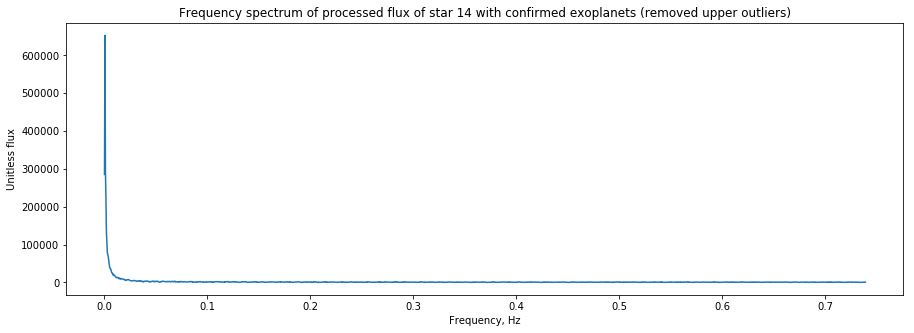

In [25]:
df = X.join(y)
i = 13
spec1 = df[df.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
plt.figure(figsize=(15,5))
plt.title('Frequency spectrum of processed flux of star {} with confirmed exoplanets (removed upper outliers)'
          .format(i+1))
plt.ylabel('Unitless flux')
plt.xlabel('Frequency, Hz')
plt.plot(freq, spec1)

Since [frequency spectra are symmetric](https://dsp.stackexchange.com/questions/4825/why-is-the-fft-mirrored), we need to remove half of all spectra:

In [26]:
X = X.iloc[:,:(X.shape[1]//2)]
X_final_test = X_final_test.iloc[:,:(X_final_test.shape[1]//2)]

Let's see what spectra look like for stars:

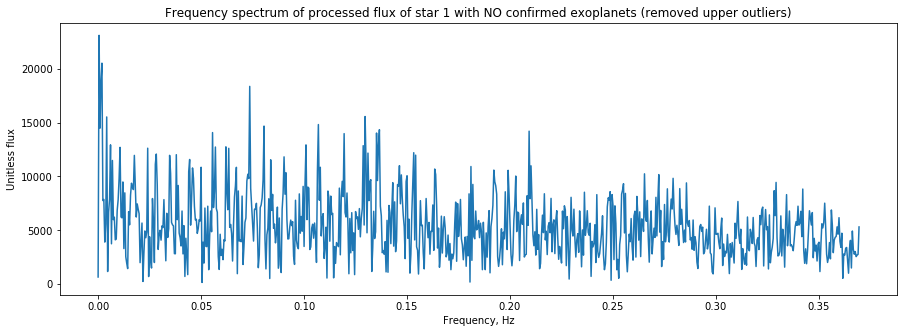

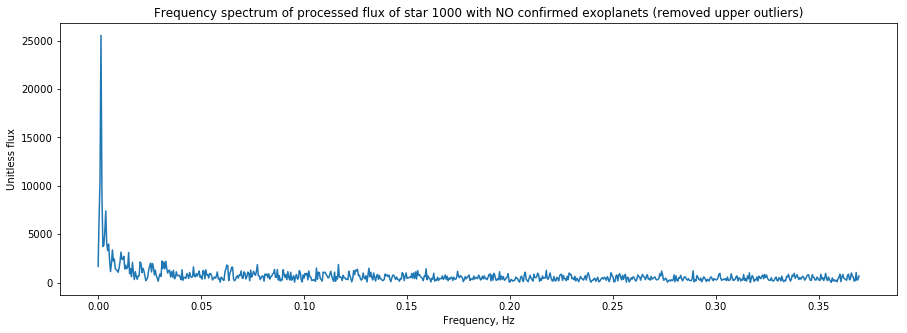

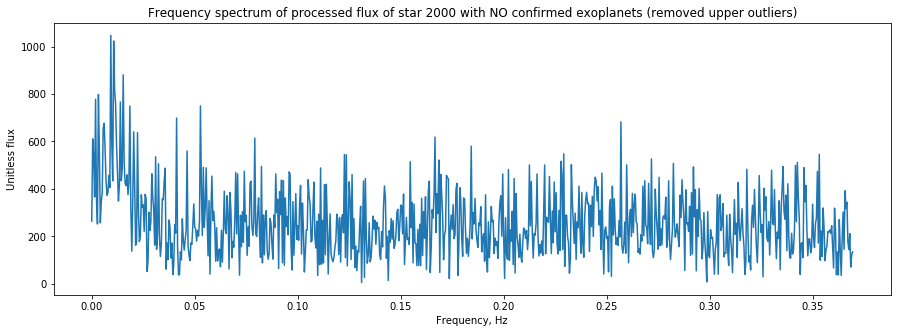

In [27]:
# Obtaining flux frequency spectra for several stars without exoplanets from the train data:
df = X.join(y)
for i in [0, 999, 1999]:
    spec1 = df[df.LABEL == 1].drop('LABEL', axis=1).iloc[i,:]
    freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
    plt.figure(figsize=(15,5))
    plt.title('Frequency spectrum of processed flux of star {} with NO confirmed exoplanets (removed upper outliers)'
              .format(i+1))
    plt.ylabel('Unitless flux')
    plt.xlabel('Frequency, Hz')
    plt.plot(freq, spec1)

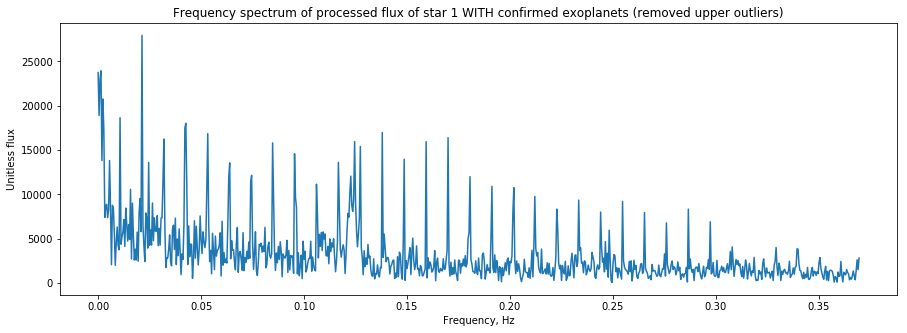

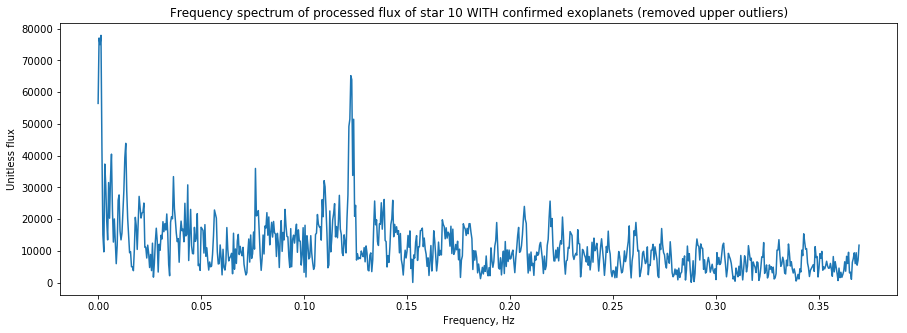

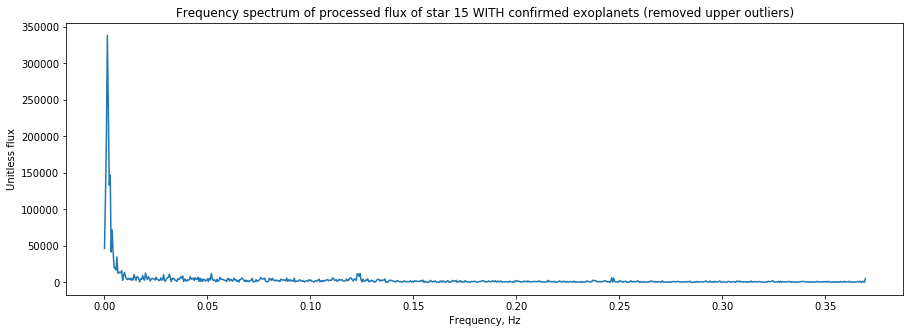

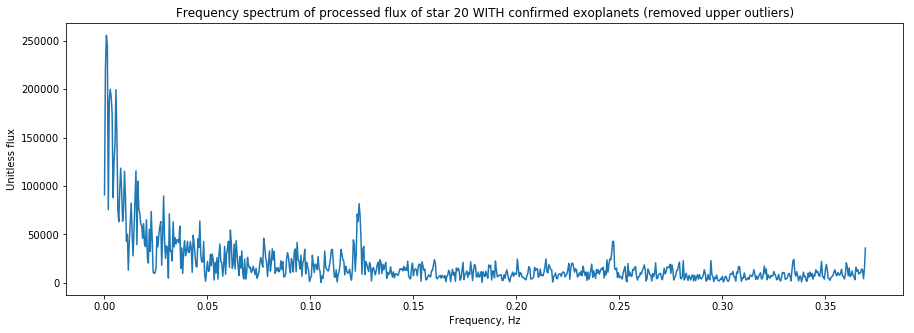

In [29]:
# Obtaining flux frequency spectra for several stars with exoplanets from the train data:
df = X.join(y)
for i in [0, 9, 14, 19]:
    spec1 = df[df.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
    freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
    plt.figure(figsize=(15,5))
    plt.title('Frequency spectrum of processed flux of star {} WITH confirmed exoplanets (removed upper outliers)'
              .format(i+1))
    plt.ylabel('Unitless flux')
    plt.xlabel('Frequency, Hz')
    plt.plot(freq, spec1)

There is a noticeable bump on the left side of spectra for stars with exoplanets, so we may have a chance at improving our models, after all!  
But first, let's do a little housekeeping.

In [30]:
X.columns

Index(['FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6', 'FLUX.7',
       'FLUX.8', 'FLUX.9', 'FLUX.10',
       ...
       'FLUX.790', 'FLUX.791', 'FLUX.792', 'FLUX.793', 'FLUX.794', 'FLUX.795',
       'FLUX.796', 'FLUX.797', 'FLUX.798', 'FLUX.799'],
      dtype='object', length=799)

Let's convert column names to frequencies they represent.

In [31]:
X_columns = np.arange(len(X.columns))
X_columns = X_columns * (1.0/(36.0*60.0)) # sampling frequency of our data
X.columns = X_columns
X_final_test.columns = X_columns

In [32]:
X.columns

Float64Index([              0.0, 0.000462962962963, 0.000925925925926,
               0.00138888888889,  0.00185185185185,  0.00231481481481,
               0.00277777777778,  0.00324074074074,   0.0037037037037,
               0.00416666666667,
              ...
                 0.365277777778,    0.365740740741,    0.366203703704,
                 0.366666666667,     0.36712962963,    0.367592592593,
                 0.368055555556,    0.368518518519,    0.368981481481,
                 0.369444444444],
             dtype='float64', length=799)

Now, let's do some modeling with our new and improved features!

## Modeling

In [35]:
model_evaluator(X, y, LinearSVC())

/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabu

			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.9806932533 	 0.9806932533
Average Precision:	 0.1450000000 	 0.1483333333
Average Recall:		 0.3166666667 	 0.3166666667
Average F1:		 0.1852380952 	 0.1888095238


In [38]:
model_evaluator(X, y, LogisticRegression(n_jobs=-1))

/Users/aleksod/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aleksod/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.9913517318 	 0.9919418963
Average Precision:	 0.3967857143 	 0.5091666667
Average Recall:		 0.5833333333 	 0.5916666667
Average F1:		 0.4664862915 	 0.5136507937


In [39]:
model_evaluator(X, y, KNeighborsClassifier(n_jobs=-1))

/Users/aleksod/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aleksod/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.9948896246 	 0.7507367387
Average Precision:	 0.7000000000 	 0.0250472544
Average Recall:		 0.4250000000 	 0.8583333333
Average F1:		 0.5057142857 	 0.0486229440


In [44]:
model_evaluator(X, y, GaussianNB())

			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.5514382841 	 0.4951982427
Average Precision:	 0.0101453869 	 0.0074205479
Average Recall:		 0.6166666667 	 0.5250000000
Average F1:		 0.0199577548 	 0.0146310875


In [72]:
model_evaluator(X, y, RandomForestClassifier(n_jobs=-1))

0      2.0
1      2.0
2      2.0
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
30     1.0
31     1.0
32     1.0
33     1.0
34     1.0
35     1.0
36     1.0
37     1.0
38     1.0
39     1.0
40     1.0
41     1.0
42     1.0
43     1.0
44     1.0
45     1.0
46     1.0
47     1.0
48     1.0
      ... 
254    1.0
255    1.0
256    1.0
257    1.0
258    1.0
259    1.0
260    1.0
261    1.0
262    1.0
263    1.0
264    1.0
265    1.0
266    1.0
267    1.0
268    1.0
269    1.0
270    1.0
271    1.0
272    1.0
273    1.0
274    1.0
275    1.0
276    1.0
277    1.0
278    1.0
279    1.0
280    1.0
281    1.0
282    1.0
283    1.0
Name: LABEL, Length: 265, dtype: float64


NameError: name 'y_true' is not defined

In [43]:
model_evaluator(X, y, SVC())

/Users/aleksod/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aleksod/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.9927273641 	 0.9927273641
Average Precision:	 0.0000000000 	 0.0000000000
Average Recall:		 0.0000000000 	 0.0000000000
Average F1:		 0.0000000000 	 0.0000000000


No huge improvements, although having a precision of 0.7 on KNN model trained with bootstrapped data is very nice considering limited resources. Let's see if normalizing spectra can make any positive difference:

In [66]:
from sklearn.preprocessing import normalize

In [67]:
X = pd.DataFrame(normalize(X))
X_final_test = pd.DataFrame(normalize(X_final_test))

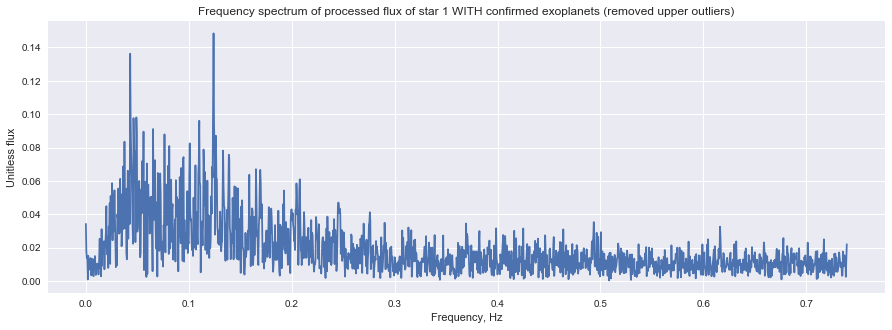

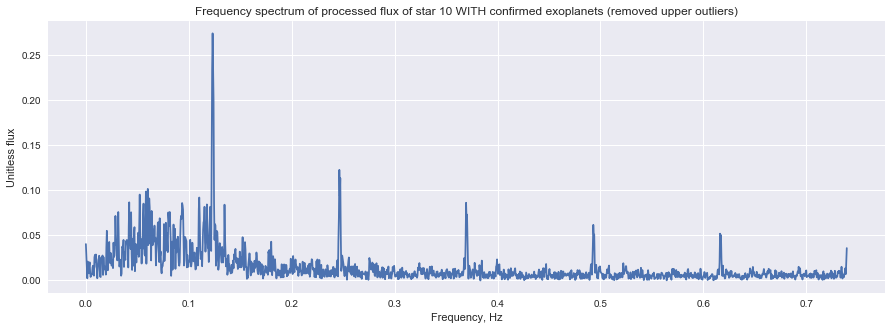

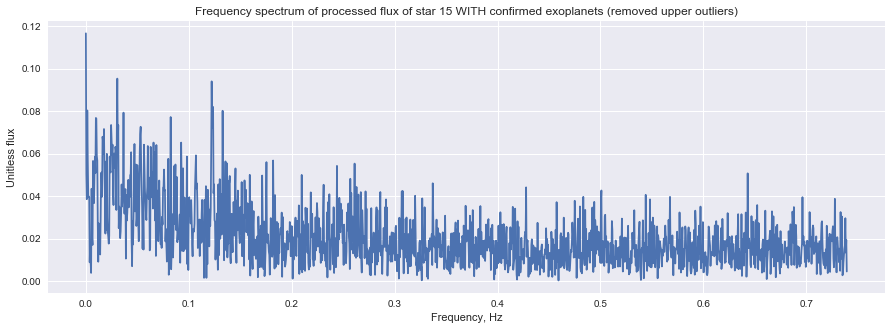

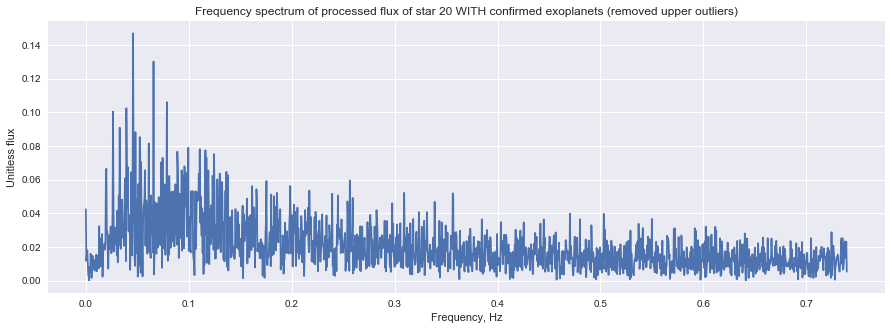

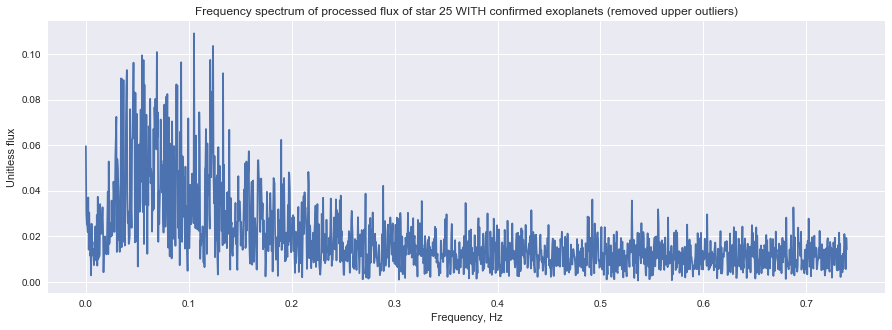

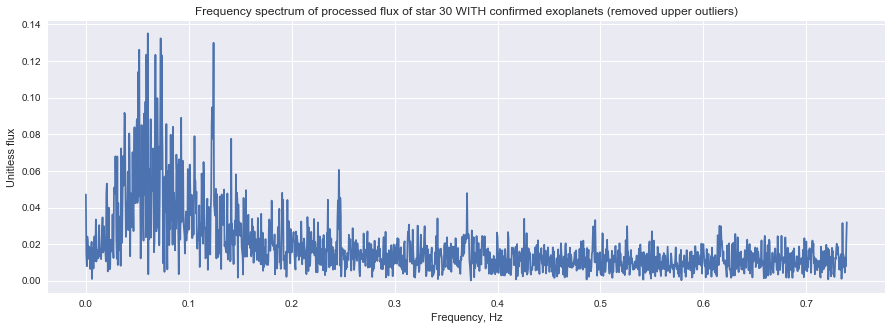

In [156]:
# Obtaining flux frequency spectra for several stars with exoplanets from the train data:
df = X.join(y)
for i in [0, 9, 14, 19, 24, 29]:
    spec1 = df[df.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
    freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
    plt.figure(figsize=(15,5))
    plt.title('Frequency spectrum of processed flux of star {} WITH confirmed exoplanets (removed upper outliers)'
              .format(i+1))
    plt.ylabel('Unitless flux')
    plt.xlabel('Frequency, Hz')
    plt.plot(freq, spec1)

In [69]:
model_evaluator(X, y, LinearSVC())

/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/suryabu

			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.9962135506 	 0.9962135506
Average Precision:	 0.7000000000 	 0.7000000000
Average Recall:		 0.5166666667 	 0.5166666667
Average F1:		 0.5800000000 	 0.5800000000


/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
model_evaluator(X, y, LogisticRegression(n_jobs=-1))

NameError: name 'LogisticRegression' is not defined

In [56]:
model_evaluator(X, y, KNeighborsClassifier(n_jobs=-1))

/Users/aleksod/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aleksod/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.9952829386 	 0.6673939947
Average Precision:	 0.7416666667 	 0.0203847129
Average Recall:		 0.4083333333 	 0.9500000000
Average F1:		 0.5121428571 	 0.0398963836


In [57]:
model_evaluator(X, y, GaussianNB())

			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.8332886005 	 0.9058270037
Average Precision:	 0.0292708003 	 0.0396873965
Average Recall:		 0.6833333333 	 0.4833333333
Average F1:		 0.0559747393 	 0.0729967432


In [70]:
model_evaluator(X, y, RandomForestClassifier(n_jobs=-1))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [61]:
model_evaluator(X, y, SVC())

			 Bootstrapped 	 SMOTE
Average Accuracy:	 0.9402371486 	 0.9433848212
Average Precision:	 0.0787366028 	 0.0833865958
Average Recall:		 0.6083333333 	 0.6083333333
Average F1:		 0.1379813824 	 0.1450440097


Looks like we found our model to optimize! We can now look closely at Linear Support Vector Classification and find most optimal parameters for it via randomized and grid searches. Perhaps, we can improve the recall rate.  
## Linear SVC Optimization through Randomized and Grid Searches

Let's see if the Randomized Search works with our data without taking it through SMOTE process. For that I will be setting `class_weight` parameter in `LinearSVC` classifier to `'balanced'`. Also, I am unsure how to tell Randomized Search that I am looking for LABEL = 2, so to avoid any confusion, I will convert all 1s to 0s and all 2s to 1s:

In [68]:
y_new = y - 1

In [70]:
from sklearn.model_selection import RandomizedSearchCV

# develop your "tuned parameters"

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print(__doc__)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y_new, test_size=0.5, stratify=y)

# Set the parameters by cross-validation
tuned_parameters = [{'penalty': ['l2'], #'l1'],
              'loss': ['hinge'],
              'dual': [True],
              'tol': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'fit_intercept': [True, False],
              'intercept_scaling': [0.01, 0.1, 1, 10, 100],
              'class_weight': ['balanced'],
              'verbose': [0],
              'random_state': [None],
              'max_iter': [10, 100, 1000, 10000, 100000]},
                    {'penalty': ['l2'], #'l1'],
              'loss': ['squared_hinge'],
              'dual': [True, False],
              'tol': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'fit_intercept': [True, False],
              'intercept_scaling': [0.01, 0.1, 1, 10, 100],
              'class_weight': ['balanced'],
              'verbose': [0],
              'random_state': [None],
              'max_iter': [10, 100, 1000, 10000, 100000]},
                   {'penalty': ['l1'],
              'loss': ['squared_hinge'], #'hinge'],
              'dual': [False],
              'tol': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'fit_intercept': [True, False],
              'intercept_scaling': [0.01, 0.1, 1, 10, 100],
              'class_weight': ['balanced'],
              'verbose': [0],
              'random_state': [None],
              'max_iter': [10, 100, 1000, 10000, 100000]}]

model_scores = ['precision', 'recall', 'f1']

for model_score in model_scores:
    print("# Tuning hyper-parameters for %s" % model_score)
    print()
    for tuned_parameter in tuned_parameters:
        clf = RandomizedSearchCV(LinearSVC(), tuned_parameter, cv=3, scoring=model_score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_estimator_)
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

LinearSVC(C=100.0, class_weight='balanced', dual=True, fit_intercept=False,
     intercept_scaling=0.1, loss='hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1.0,
     verbose=0)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1310
          1       1.00      0.18      0.31        11

avg / total       0.99      0.99      0.99      1321


Best parameters set found on development set:

LinearSVC(C=1000.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
     verbose=0)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on t

/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3

Best parameters set found on development set:

LinearSVC(C=10.0, class_weight='balanced', dual=False, fit_intercept=False,
     intercept_scaling=0.1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.01,
     verbose=0)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1310
          1       0.60      0.27      0.37        11

avg / total       0.99      0.99      0.99      1321


# Tuning hyper-parameters for recall

Best parameters set found on development set:

LinearSVC(C=0.001, class_weight='balanced', dual=True, fit_intercept=False,
     intercept_scaling=100, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=1.0, verbose=0)

Detailed classification report:

The model is trained on the full development 

/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/suryabulusu/miniconda3/lib/pyt

Best parameters set found on development set:

LinearSVC(C=10.0, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=0.01, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.1,
     verbose=0)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1310
          1       0.60      0.27      0.37        11

avg / total       0.99      0.99      0.99      1321




Let's see if we can do better with SMOTE data balancing. This time `class_weight` is going to be `None` since the data will be balanced through synthetic data generation:

In [71]:
def SMOTE_synthesizer(X, y):
        sm = SMOTE(ratio = 1.0)
        X, y = sm.fit_sample(X, y)
        return X, y

In [39]:
from sklearn.model_selection import RandomizedSearchCV

# develop your "tuned parameters"

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print(__doc__)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y_new, test_size=0.5, stratify=y)

X_train, y_train = SMOTE_synthesizer(X_train, y_train)

# Set the parameters by cross-validation
tuned_parameters = [{'penalty': ['l2'], #'l1'],
              'loss': ['hinge'],
              'dual': [True],
              'tol': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'fit_intercept': [True, False],
              'intercept_scaling': [0.01, 0.1, 1, 10, 100],
              'class_weight': [None],
              'verbose': [0],
              'random_state': [None],
              'max_iter': [10, 100, 1000, 10000, 100000]},
                    {'penalty': ['l2'], #'l1'],
              'loss': ['squared_hinge'],
              'dual': [True, False],
              'tol': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'fit_intercept': [True, False],
              'intercept_scaling': [0.01, 0.1, 1, 10, 100],
              'class_weight': [None],
              'verbose': [0],
              'random_state': [None],
              'max_iter': [10, 100, 1000, 10000, 100000]},
                   {'penalty': ['l1'],
              'loss': ['squared_hinge'], #'hinge'],
              'dual': [False],
              'tol': [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              'fit_intercept': [True, False],
              'intercept_scaling': [0.01, 0.1, 1, 10, 100],
              'class_weight': [None],
              'verbose': [0],
              'random_state': [None],
              'max_iter': [10, 100, 1000, 10000, 100000]}]

model_scores = ['precision', 'recall', 'f1']

for model_score in model_scores:
    print("# Tuning hyper-parameters for %s" % model_score)
    print()
    for tuned_parameter in tuned_parameters:
        clf = RandomizedSearchCV(LinearSVC(), tuned_parameter, cv=3, scoring=model_score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_estimator_)
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=10, loss='hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2525
          1       1.00      0.47      0.64        19

avg / total       1.00      1.00      1.00      2544


Best parameters set found on development set:

LinearSVC(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=0.1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1e-05,
     verbose=0)

Detailed cla

So at the end of the day, it still looks like training on synthetic data works better than balancing. For models trained with SMOTE data, my best `precision`, `recall`, and `f1` scores were `1.00`, `0.47`, and `0.64`, respectively. For models that try to balance training data, my best `precision`, `recall`, and `f1` scores were `1.00`, `0.37`, and `0.54`, respectively. The best scores for SMOTE trained models were achieved with the following parameters:
```python
LinearSVC(
    C=100.0,
    class_weight=None,
    dual=True,
    fit_intercept=True,
    intercept_scaling=10,
    loss='hinge',
    max_iter=100000,
    multi_class='ovr',
    penalty='l2',
    random_state=None,
    tol=0.0001,
    verbose=0)```
Therefore, we shall now proceed with the Grid Search to zoom in on possible settings around these parameters:

In [30]:
from sklearn.grid_search import GridSearchCV

# develop your "tuned parameters"

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y_new, test_size=0.5, stratify=y)

X_train, y_train = SMOTE_synthesizer(X_train, y_train)

# Set the parameters by cross-validation
tuned_parameters = {'penalty': ['l2'],
              'loss': ['hinge'],
              'dual': [True],
              'tol': np.arange(0.00008, .00014, 0.00002),
              'C': list(range(100, 220, 20)),
              'fit_intercept': [True],
              'intercept_scaling': np.arange(10, 130, 30),
              'class_weight': [None],
              'verbose': [0],
              'random_state': [None]}
#               'max_iter': np.arange(10000, 130000, 30000)}

# LinearSVC(
#     C=100.0,
#     class_weight=None,
#     dual=True,
#     fit_intercept=True,
#     intercept_scaling=10,
#     loss='hinge',
#     max_iter=100000,
#     multi_class='ovr',
#     penalty='l2',
#     random_state=None,
#     tol=0.0001,
#     verbose=0)

model_scores = ['precision', 'recall', 'f1']

for model_score in model_scores:
    print("# Tuning hyper-parameters for %s" % model_score)
    print()

    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=3, scoring=model_score, n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/home/aleksod/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best parameters set found on development set:

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=10, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=8.0000000000000007e-05,
     verbose=0)

Grid scores on development set:

1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 8.0000000000000007e-05, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 0.00012, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_in

/home/aleksod/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Best parameters set found on development set:

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=10, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=8.0000000000000007e-05,
     verbose=0)

Grid scores on development set:

1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 8.0000000000000007e-05, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 0.00012, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_in

/home/aleksod/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Best parameters set found on development set:

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=10, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=8.0000000000000007e-05,
     verbose=0)

Grid scores on development set:

1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 8.0000000000000007e-05, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 10, 'loss': 'hinge', 'penalty': 'l2', 'random_state': None, 'tol': 0.00012, 'verbose': 0}
1.000 (+/-0.000) for {'C': 100, 'class_weight': None, 'dual': True, 'fit_in

/home/aleksod/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Unfortunately, none of the parameter searches yielded results better than our initial default LinearSVC() model. Therefore, we shall proceed and create our final model uising default parameters of LinearSVC():

## Final Model

In [72]:
X_sm, y_sm = SMOTE_synthesizer(X, y)

/home/suryabulusu/miniconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [73]:
final_model = LinearSVC()
final_model.fit(X_sm, y_sm)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [74]:
y_pred = final_model.predict(X_final_test)

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_final_test, y_pred))

             precision    recall  f1-score   support

          1       0.99      1.00      1.00      1307
          2       0.75      0.27      0.40        11

avg / total       0.99      0.99      0.99      1318



This is a good precision and recall, especially in comparison with earlier baseline models. It will be interesting to see the adoption of such approach to star flux analysis in further K2 campaigns.